# VLMap Creation

In [33]:
# setup parameters
cs = 0.05 # meters per cell size
gs = 1000 # map resolution
camera_height = 1.5 # camera ground distance
depth_sample_rate = 100 # depth pixels subsample rate
data_dir = "/home/huang/hcg/projects/vln/data/clip_mapping/sim_new/5LpN3gDmAk7_1" # data where rgb, depth, pose are loaded and map are saved

In [34]:
from examples.clip_mapping_lseg_from_scratch_batch import create_lseg_map_batch
create_lseg_map_batch(data_dir, camera_height=camera_height, cs=cs, gs=gs, depth_sample_rate=depth_sample_rate)

cuda
Loading CLIP model...
Creating LSegEncNet model...
Creating time 19.511632919311523s.
Loading pretrained model...
Loading time 35.74900984764099s.
Filtering pretrained model...
Assigning pretrained model parameters to model...
loading scene /home/huang/hcg/projects/vln/data/clip_mapping/sim_new/5LpN3gDmAk7_1
/home/huang/hcg/projects/vln/data/clip_mapping/sim_new/5LpN3gDmAk7_1/map/color_top_down_1.npy is saved.
/home/huang/hcg/projects/vln/data/clip_mapping/sim_new/5LpN3gDmAk7_1/map/grid_1_gt.npy is saved.
/home/huang/hcg/projects/vln/data/clip_mapping/sim_new/5LpN3gDmAk7_1/map/grid_lseg_1.npy is saved.
/home/huang/hcg/projects/vln/data/clip_mapping/sim_new/5LpN3gDmAk7_1/map/weight_lseg_1.npy is saved.
/home/huang/hcg/projects/vln/data/clip_mapping/sim_new/5LpN3gDmAk7_1/map/obstacles.npy is saved.
empty map saved
first image read
Running iteration 0
Process reading image, pose, and depth takes 9.043508291244507s.


/home/huang/anaconda3/envs/lseg_map/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Process generating lseg features takes 3.2169759273529053s.
Process projecting features takes 0.07021212577819824s.
Iteration time: 12.684015274047852
Running iteration 1
Process reading image, pose, and depth takes 0.0961003303527832s.
Process generating lseg features takes 0.7257053852081299s.
Process projecting features takes 0.15082955360412598s.
Iteration time: 1.1258466243743896
Running iteration 2
Process reading image, pose, and depth takes 1.4077553749084473s.
Process generating lseg features takes 0.7137417793273926s.
Process projecting features takes 0.15670180320739746s.
Iteration time: 3.764981269836426
Running iteration 3
Process reading image, pose, and depth takes 1.0878570079803467s.
Process generating lseg features takes 0.7096552848815918s.
Process projecting features takes 0.207319974899292s.
Iteration time: 2.403644323348999
Running iteration 4
Process reading image, pose, and depth takes 0.47156786918640137s.
Process generating lseg features takes 0.70837283134460

# Landmark Indexing

## Load packages

In [35]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.clip_mapping_utils import *
from utils.clip_utils import *
from utils.mp3dcat import mp3dcat
import clip

## Setup Load Paths

In [36]:
map_save_dir = os.path.join(data_dir, "map_correct")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_1.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_lseg_1.npy")
obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")



## Show Obstacle Map

[0 1]


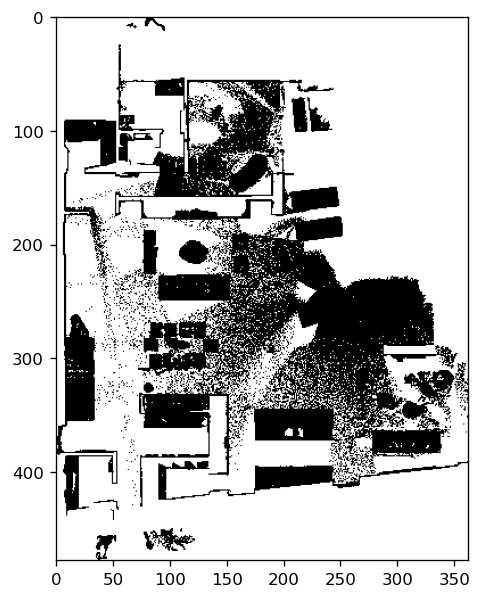

In [37]:
obstacles = load_map(obstacles_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

## Show Top-Down Color Map

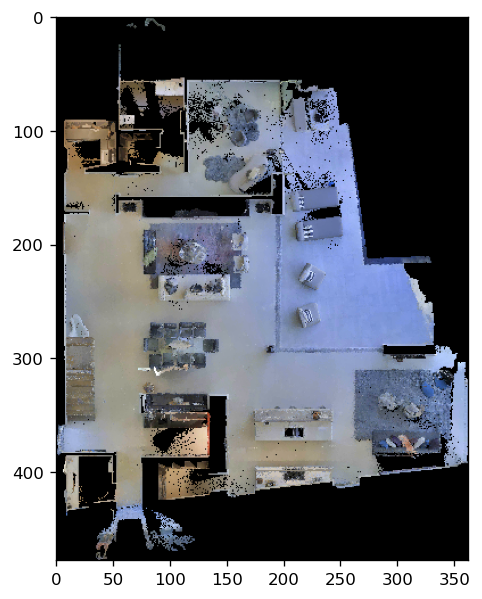

In [38]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.show()


## Show Landmark Indexing Results

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
clip_model.to(device).eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [40]:
grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]

(478, 363)


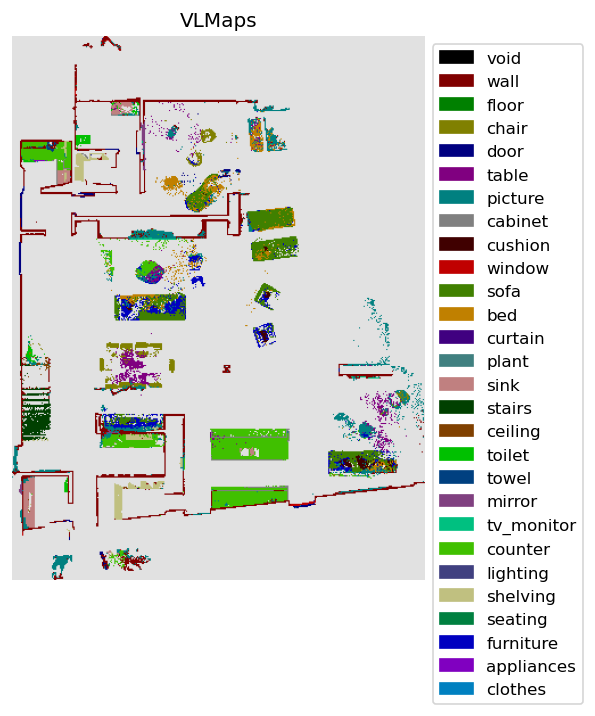

In [41]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)
print(no_map_mask.shape)

lang = mp3dcat 
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

In [42]:
import cv2
import matplotlib.animation
from IPython.display import Video
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline
rgb_dir = os.path.join(data_dir, "rgb")
rgb_list = os.listdir(rgb_dir)
rgb_list = sorted([os.path.join(rgb_dir, x) for x in rgb_list], key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))
plt.figure()
# out = cv2.VideoWriter("tmp.avi", cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 10.0, (1080, 720))
out = cv2.VideoWriter('tmp.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (1080, 720))
for i, rgb_path in enumerate(rgb_list):
    if i > 5:
        break
    bgr = cv2.imread(rgb_path)
    out.write(bgr)
out.release()
cv2.destroyAllWindows()


<Figure size 432x288 with 0 Axes>

In [43]:
from base64 import b64encode
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)
Video("/home/huang/hcg/projects/vln/relevant_code/vlmaps/tmp.avi", embed=True)